In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
from tensorflow.keras.models import load_model
import pandas as pd
import glob

In [5]:
patch_size=256
from custom_functions import crop_image, padder
from custom_metrics import f1,iou

In [6]:
# Define custom_objects dictionary with your metric functions
custom_objects = {'f1': f1, 'iou': iou}

# Load the model using the custom_objects parameter
root_model = load_model('root_model.h5', custom_objects=custom_objects)

In [7]:
# Predict patches with coordinates
def predict_patches(image_path, model, patch_size):
    # Read, crop and patch
    image = cv2.imread(image_path)
    image, coordinates =crop_image(image)
    image = padder(image, patch_size)
    patches = patchify(image, (patch_size, patch_size, 1), step=patch_size)
    # Adjust patches for prediction
    i = patches.shape[0]
    j = patches.shape[1]
    patches = patches.reshape(-1, patch_size, patch_size, 1)
    patches.shape
    #predict
    preds = model.predict(patches/255,verbose=0) 
    preds = preds.reshape(i, j, patch_size, patch_size)
    preds.shape
    
    return image, preds, coordinates

## Instance segmentation from Task 5

In [8]:
def instance_segmentation(image_path, patch_size=patch_size):
    image, preds, coordinates = predict_patches(image_path, root_model, patch_size)
    predictions = unpatchify(preds, (image.shape[0], image.shape[1]))
    _, thresholded_image = cv2.threshold(predictions, 0.4, 1, cv2.THRESH_BINARY)
    thresholded_image = thresholded_image.astype('uint8')

    # Extract connected components using connectedComponentsWithStats
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(thresholded_image, 8, cv2.CV_32S)
    stats_indices = sorted(range(1, retval), key=lambda x: cv2.boundingRect((labels == x).astype(np.uint8))[0])

    blank = np.zeros_like(thresholded_image)
    nr_instances = 0
    instances = []
    # Filtering elements based on criteria
    for label_index in stats_indices:
        stat = stats[label_index]
        x, y, w, h, a = stat
        if h > 400:
            if nr_instances<5:
                # Drawing the elements on the blank image
                mask = (labels == label_index).astype(np.uint8)
                blank[mask > 0] = label_index
                _, thresholded_plant = cv2.threshold(blank, 0.1, 1, cv2.THRESH_BINARY)
                thresholded_plant = thresholded_plant.astype('uint8')

                instances.append(thresholded_plant)
                # Reset the blank image for the next instance
                blank = np.zeros_like(thresholded_image)
                nr_instances += 1

    print(nr_instances)
    return instances, coordinates

## Landmark detection

The black circle is the primary root tip. The green circle is the junction between the primary root and the hypocotyl. The red circles are the lateral root tips. The blue circles are the landmarks where lateral roots branch out from the primary root.

Instance segmentation cropps image for better accuracy. Therefore, the coordinates of landmarks was adjusted from cropped image to the whole image for error analysis

In [9]:
from skan.csr import skeleton_to_csgraph
from skimage.morphology import skeletonize
import networkx as nx

In [10]:
# Function to find endpoints and branch points
def find_landmarks(coordinates, degrees):
    tip_indices = np.where(degrees == 1)[0]  # Indices of end-points
    branch_indices = np.where(degrees > 2)[0]  # Indices of branch points
    tips = coordinates[tip_indices]
    branches = coordinates[branch_indices]
    return tips, branches

5


C:\Users\korne\AppData\Local\Temp\ipykernel_16496\3905750147.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


5


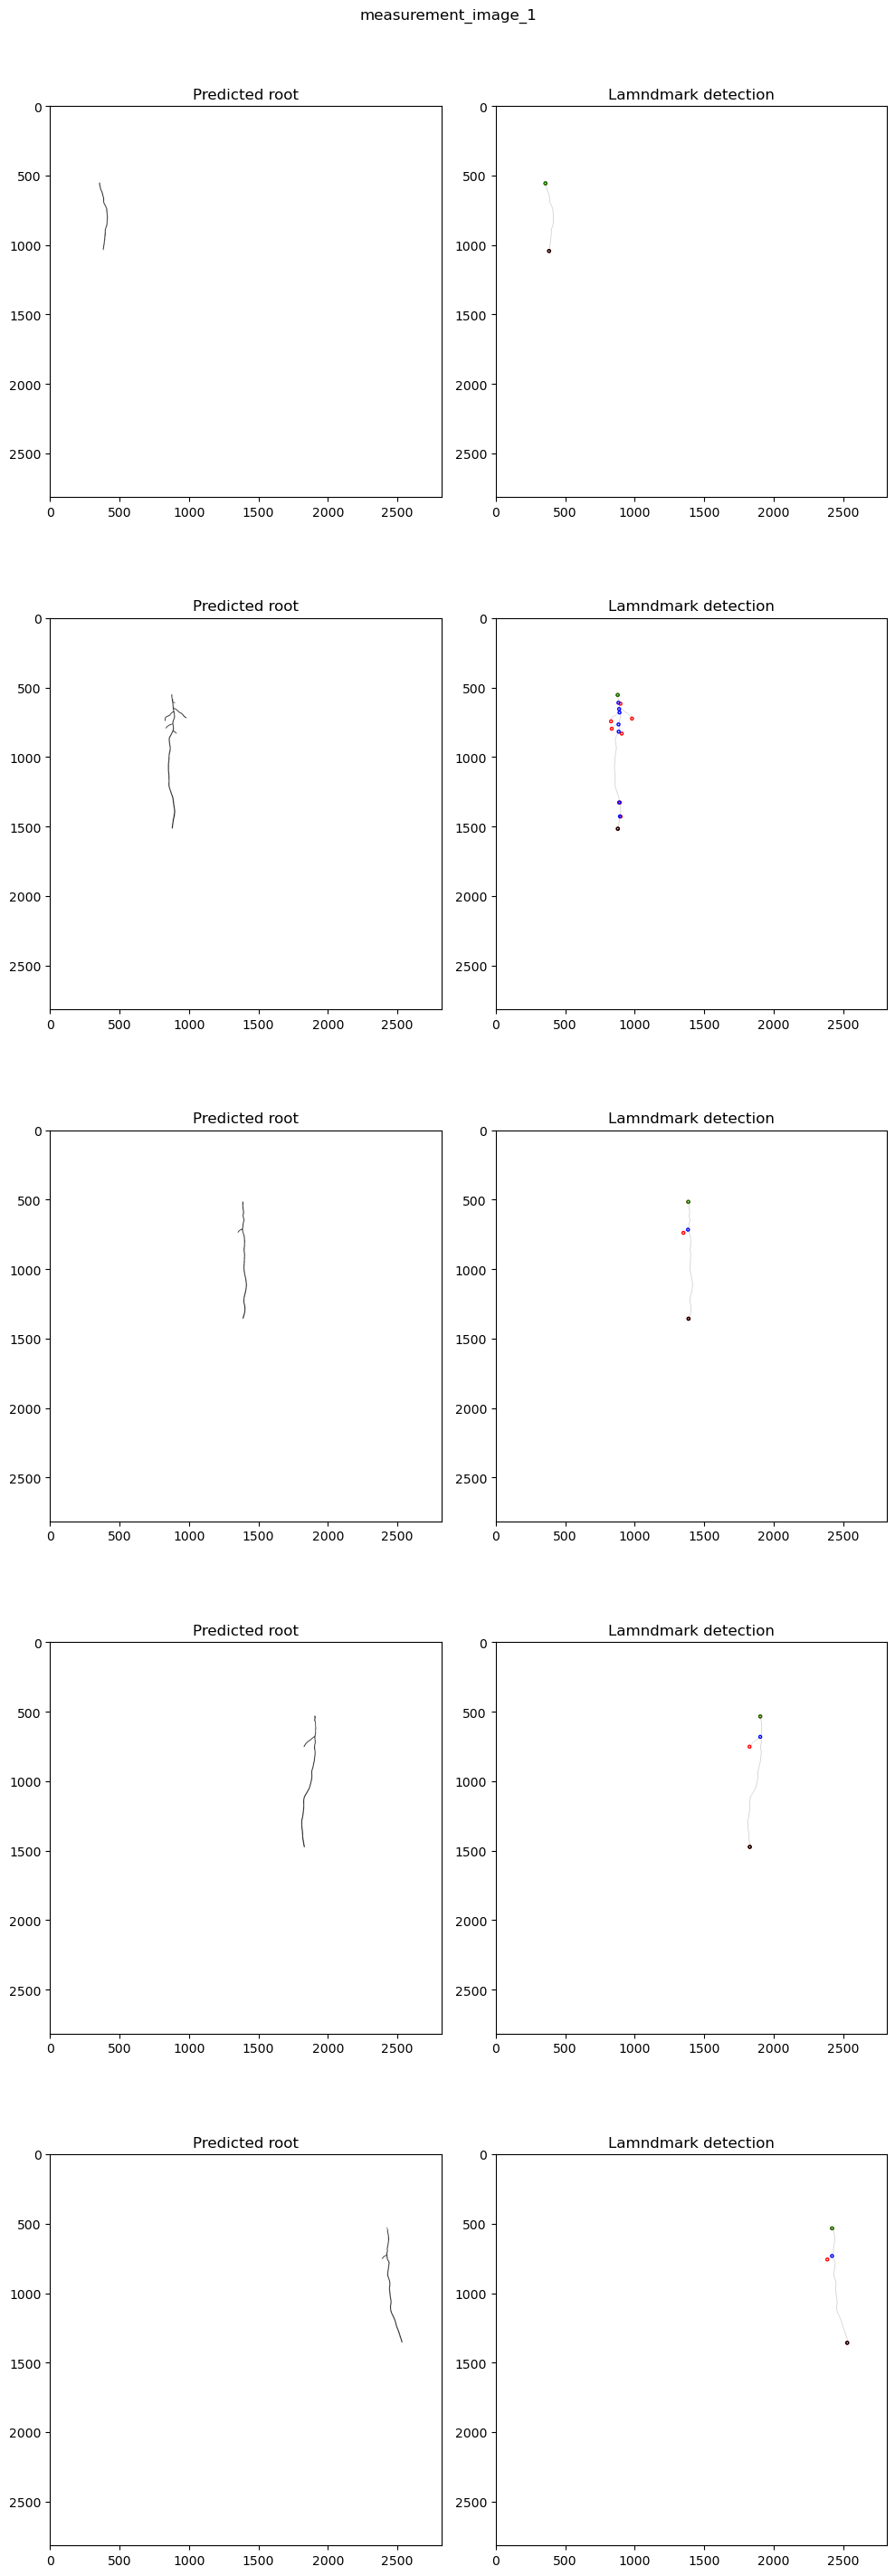

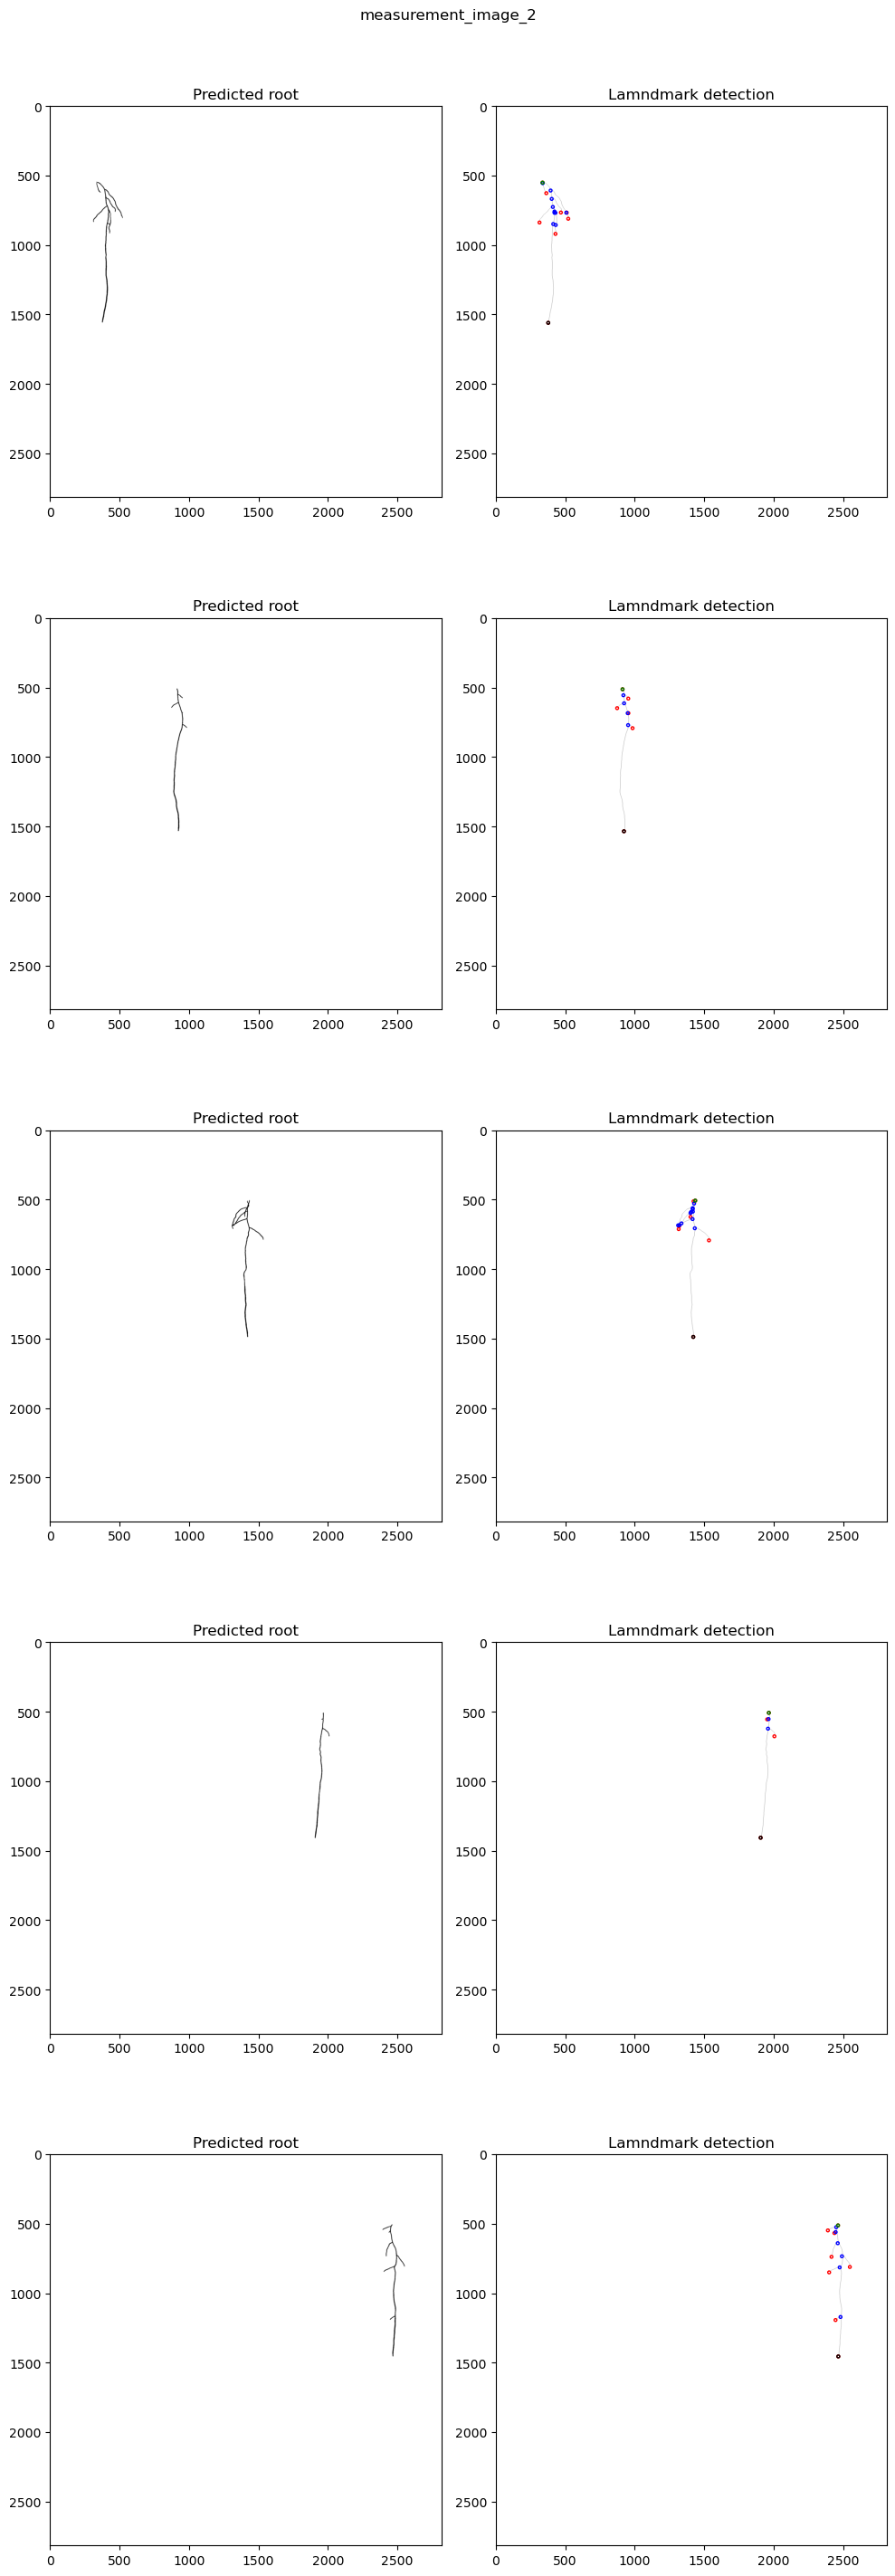

In [11]:
results=[]
for image_path in sorted(glob.glob('Measurement_dataset/measurement_image*')):
    filename=image_path[20:-4]
    plants, coordinates_crop=instance_segmentation(image_path)
    x_before_crop=coordinates_crop[0]
    y_before_crop=coordinates_crop[1]
    
    fig, axs = plt.subplots(len(plants), 2, figsize=(10, 30))
    for i, roi in enumerate(plants):
        roi[roi!=0]=1
        axs[i][0].imshow(255-roi, cmap='gray')
        axs[i][0].set_title("Predicted root")
        # Assuming binary1 and binary2 are your binary images for skeletonization
        skeleton = skeletonize(roi)
        
        # Convert skeletons to graph representations
        graph, coordinates_tuple = skeleton_to_csgraph(skeleton)
        
        # Convert tuples to 2D arrays of coordinates
        coordinates = np.column_stack(coordinates_tuple)
        
        # Convert to networkx graphs to calculate degrees
        nx_graph = nx.Graph(graph)
        degrees = np.array([val for (node, val) in nx_graph.degree()])
        
        # Find landmarks for both skeletons
        tips, branches = find_landmarks(coordinates, degrees)
        
        circle_radius = 10  # Radius for the circles around landmarks

        axs[i][1].imshow(255-skeleton, cmap='gray')
        axs[i][1].set_title("Lamndmark detection")
        for tip in tips:
            axs[i][1].add_patch(plt.Circle((tip[1], tip[0]), circle_radius, edgecolor='red', fill=False))  # Red circles for tips
        for branch in branches:
            axs[i][1].add_patch(plt.Circle((branch[1], branch[0]), circle_radius, edgecolor='blue', fill=False))  # Blue circles for branches
        if tips.size > 0:  # Check if there are any tips
            top_of_root = min(tips, key=lambda x: x[0])
            bottom_of_root = max(tips, key=lambda x: x[0])
            axs[i][1].add_patch(plt.Circle((top_of_root[1], top_of_root[0]),circle_radius, edgecolor='green', fill=False))  # Green for top of root
            axs[i][1].add_patch(plt.Circle((bottom_of_root[1], bottom_of_root[0]),circle_radius, edgecolor='black', fill=False))  # Black for bottom of root
        
        fig.suptitle(filename)
        fig.tight_layout()
        fig.show()

        V1_x= top_of_root[1]+x_before_crop
        V1_y= top_of_root[0]+y_before_crop
        V2_x= bottom_of_root[1]+x_before_crop
        V2_y= bottom_of_root[0]+y_before_crop  

        measurements = pd.DataFrame({'Plant ID ':[f'{filename}_plant_{i+1}'], 'V1 x': [V1_x],'V1 y': [V1_y], 'V2 x': [V2_x], 'V2 y': [V2_y]})
        results.append(measurements)
     
results_df = pd.concat(results, ignore_index=True)
    

## Performance

In [12]:
results_df

,Plant ID,V1 x,V1 y,V2 x,V2 y
0,measurement_image_1_plant_1,1110,623,1136,1110
1,measurement_image_1_plant_2,1630,620,1631,1583
2,measurement_image_1_plant_3,2138,583,2140,1424
3,measurement_image_1_plant_4,2656,601,2581,1540
4,measurement_image_1_plant_5,3173,600,3282,1424
5,measurement_image_2_plant_1,1089,617,1130,1626
6,measurement_image_2_plant_2,1665,578,1675,1600
7,measurement_image_2_plant_3,2188,573,2174,1554
8,measurement_image_2_plant_4,2718,574,2659,1473
9,measurement_image_2_plant_5,3216,578,3218,1521


In [13]:
measurements_df= pd.read_csv('Measurement_dataset\measurements_task_6.csv', delimiter=';')
measurements_df

,Plant ID,V1 x,V1 y,V2 x,V2 y
0,measurement_image_1_plant_1,1089,597,1108,1228
1,measurement_image_1_plant_2,1604,585,1611,1558
2,measurement_image_1_plant_3,2118,570,2119,1401
3,measurement_image_1_plant_4,2560,605,2635,1519
4,measurement_image_1_plant_5,3158,597,3260,1404
5,measurement_image_2_plant_1,1092,611,1121,1542
6,measurement_image_2_plant_2,1639,547,1656,1584
7,measurement_image_2_plant_3,2152,612,2154,1531
8,measurement_image_2_plant_4,2639,1451,2699,547
9,measurement_image_2_plant_5,3191,553,3198,1502


In [14]:
# Mean absolute error 
absolute_differences = abs(results_df - measurements_df)

mae = absolute_differences.mean().mean()

print(f"Mean Absolute Error: {mae.round(2)}")

Mean Absolute Error: 73.35
